# Part 1: Building an item-item recommendation system from scratch

In this tutorial, we will investigate item-item recommendations. If you use Netflix, you will notice that there is a section titled "Because you watched Movie X", which provides recommendations for movies based on a recent movie (Movie X) that you watched. This is a classic example of an item-item recommendation. 

We will be generating item-item recommendations by clustering movies together using a variety of similarity metrics. Let's get started! 

In [31]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

### Import Dataset

Let's download a small version of the [MovieLens](https://www.wikiwand.com/en/MovieLens) dataset. See [here](https://grouplens.org/datasets/movielens/) for zip file url, or directly download [here](http://files.grouplens.org/datasets/movielens/ml-latest-small.zip). We're working with data in `ml-latest-small.zip` and will need to add the following files to our repository: 
- ratings.csv
- movies.csv

Alternatively, you can access the data here: 
- https://s3-us-west-2.amazonaws.com/recommender-tutorial/movies.csv
- https://s3-us-west-2.amazonaws.com/recommender-tutorial/ratings.csv

In this tutorial, we will use Pandas DataFrames to represent our data.

#### What is a DataFrame? 

- a two-dimensional Pandas data structure
- columns represent features, rows represent items
- analogous to an Excel spreadsheet or SQL table 
- documentation can be found [here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.html)

Pandas' `read_csv` method can read csv files into a dataframe. For the code in this notebook to work, move the appropriate csv files into a directory called `data/`.

In [32]:
ratings = pd.read_csv("data/ratings.csv")
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [33]:
movies = pd.read_csv("data/movies.csv")
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


### Exploratory Data Analysis

We are working with two datasets: `ratings` and `movies`. `Ratings` contains each user's rating towards a given movie. `Movies` contains movie metadata including title, year released, and genres. This data is "messy" and will need to be pre-processed.

In [34]:
n_ratings = len(ratings)
n_movies = ratings['movieId'].nunique()
n_users = ratings['userId'].nunique()


print("Number of ratings:", n_ratings)
print("Number of unique movieId's:", n_movies)
print("Number of unique users:", n_users)
print("Average number of ratings per user:", round(n_ratings/n_users, 2))
print("Average number of ratings per movie:", round(n_ratings/n_movies, 2))

Number of ratings: 100836
Number of unique movieId's: 9724
Number of unique users: 610
Average number of ratings per user: 165.3
Average number of ratings per movie: 10.37


Now, let's create a dataframe that represents users' rating frequencies. We can do this using pandas' `groupby` and `count` which groups the data by `userId`'s and count the frequency of each userId. The frequency of a given userId represents the number of times that the user has rated a movie.

In [35]:
user_freq = ratings[['userId', 'movieId']].groupby('userId').count()
user_freq.head()

,movieId
userId,
1,232
2,29
3,39
4,216
5,44


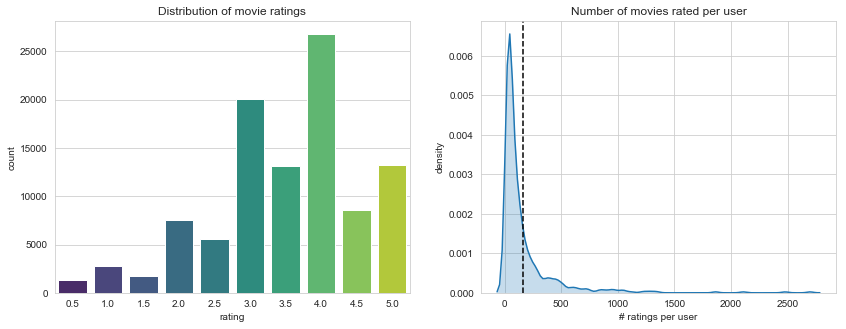

In [36]:
sns.set_style("whitegrid")
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
ax = sns.countplot(x="rating", data=ratings, palette="viridis")
plt.title("Distribution of movie ratings")

plt.subplot(1,2,2)
ax = sns.kdeplot(user_freq['movieId'], shade=True, legend=False)
plt.axvline(user_freq['movieId'].mean(), color="k", linestyle="--")
plt.xlabel("# ratings per user")
plt.ylabel("density")
plt.title("Number of movies rated per user")
plt.show()

### Which movie has the lowest and highest average rating?

In [37]:
mean_rating = ratings.groupby('movieId')[['rating']].mean()

lowest_rated = mean_rating['rating'].idxmin()
movies.loc[movies['movieId'] == lowest_rated]

,movieId,title,genres
2689,3604,Gypsy (1962),Musical


Santa with Muscles is the worst rated movie!

In [38]:
highest_rated = mean_rating['rating'].idxmax()
movies.loc[movies['movieId'] == highest_rated]

,movieId,title,genres
48,53,Lamerica (1994),Adventure|Drama


Lamerica is the highest rated movie. That being said, it's important to note that mean rating might not be the best measure of movie quality because it's very possible that this movie only had 1 rating of 5.0. 

### A Glimpse at Movie Genres

The `movies` dataset needs to be cleaned in two ways:

- `genres` is expressed as a string with a pipe `|` separating each genre. We will manipulate this string into a list, which will make it much easier to analyze.
- `title` currently has (year) appended at the end. We will extract year from each title string and create a new column for it.


In [39]:
movies["genres"] = movies["genres"].apply(lambda x: x.split("|"))
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]"
1,2,Jumanji (1995),"[Adventure, Children, Fantasy]"
2,3,Grumpier Old Men (1995),"[Comedy, Romance]"
3,4,Waiting to Exhale (1995),"[Comedy, Drama, Romance]"
4,5,Father of the Bride Part II (1995),[Comedy]


### How many genres are there?

Let's count the frequency of each unique genre by iterating through the `genres` column of our `movies` dataframe. We can use `Counter` from base Python's `collections` package to count the genres in our dataset and store it in an efficient way.

In [40]:
from collections import Counter

genre_frequency = Counter(g for genres in movies['genres'] for g in genres)

print("There are {:d} genres.".format(len(genre_frequency)))

genre_frequency

There are 20 genres.


Counter({'Adventure': 1263,
         'Animation': 611,
         'Children': 664,
         'Comedy': 3756,
         'Fantasy': 779,
         'Romance': 1596,
         'Drama': 4361,
         'Action': 1828,
         'Crime': 1199,
         'Thriller': 1894,
         'Horror': 978,
         'Mystery': 573,
         'Sci-Fi': 980,
         'War': 382,
         'Musical': 334,
         'Documentary': 440,
         'IMAX': 158,
         'Western': 167,
         'Film-Noir': 87,
         '(no genres listed)': 34})

In [41]:
print("The 5 most common genres: \n", genre_frequency.most_common(5))

The 5 most common genres: 
 [('Drama', 4361), ('Comedy', 3756), ('Thriller', 1894), ('Action', 1828), ('Romance', 1596)]


### Cleaning up the `title` column

Our second data cleaning task is to clean up the `title` column by removing the year. Let's do this by first creating a function that can clean a single 'title' string, then apply it to the entire dataframe using pandas' `apply` method.

In [42]:
title = movies['title'][0]

print(title)

def get_title(title):
    t = title.split(' ')
    t.pop()
    t = ' '.join(t)
    return t

get_title(title)

Toy Story (1995)


'Toy Story'

In [43]:
def get_year(title):
    t = title.split(' ')
    year = t.pop()
    year = year.strip('()')
    return year

get_year(title)

'1995'

In [44]:
movies['year'] = movies['title'].apply(get_year)
movies['title'] = movies['title'].apply(get_title)

We now have a nice, clean dataframe with proper `title` and `year` columns. Let's take a peak at the first couple of rows.

In [45]:
movies.head(2)

,movieId,title,genres,year
0,1,Toy Story,"[Adventure, Animation, Children, Comedy, Fantasy]",1995
1,2,Jumanji,"[Adventure, Children, Fantasy]",1995


## Transforming the data

We are going to use a technique called [colaborative filtering]() to generate recommendations for users. This technique is based on the concept of "homophily" - similar users will like similar things. Collaborative filtering is a type of unsupervised learning that extracts meaning items for a given user based on what other similar users have liked. 

The first step is to transform our data into a user-item matrix - also known as a "utility" matrix. In this matrix, rows represent users and columns represent items. The beauty of collaborative filtering is that it doesn't require any user or item features to generate recommendations.

<img src="images/user-movie-matrix.png" width="500px" align="left">

The `create_X()` function outputs a sparse matrix X with four mapper dictionaries:
- **user_mapper:** maps user id to user index
- **movie_mapper:** maps movie id to movie index
- **user_inv_mapper:** maps user index to user id
- **movie_inv_mapper:** maps movie index to movie id

We need these dictionaries because they map which row/column of the utility matrix corresponds to which user/movie ID.

The **X** (user-item) matrix is a [scipy.sparse.csr_matrix](scipylinkhere) which stores the data sparsely.

In [46]:
from scipy.sparse import csr_matrix

def create_X(df):
    """
    Generates a sparse matrix from ratings dataframe.
    
    Args:
        df: pandas dataframe
    
    Returns:
        X: sparse matrix
        user_mapper: dict that maps user id's to user indices
        user_inv_mapper: dict that maps user indices to user id's
        movie_mapper: dict that maps movie id's to movie indices
        movie_inv_mapper: dict that maps movie indices to movie id's
    """
    N = df['userId'].nunique()
    M = df['movieId'].nunique()

    user_mapper = dict(zip(np.unique(df["userId"]), list(range(N))))
    movie_mapper = dict(zip(np.unique(df["movieId"]), list(range(M))))
    
    user_inv_mapper = dict(zip(list(range(N)), np.unique(df["userId"])))
    movie_inv_mapper = dict(zip(list(range(M)), np.unique(df["movieId"])))
    
    user_index = [user_mapper[i] for i in df['userId']]
    movie_index = [movie_mapper[i] for i in df['movieId']]

    X = csr_matrix((df["rating"], (movie_index, user_index)), shape=(M, N))
    
    return X, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper

In [47]:
X, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper = create_X(ratings)

Let's check out the sparsity of our X matrix.

Here, we calculate sparsity by dividing the number of non-zero elements by total number of elements as described in the equation below: 

$$S=\frac{\text{# non-zero elements}}{\text{total elements}}$$

In [48]:
sparsity = X.count_nonzero()/(X.shape[0]*X.shape[1])

print("Matrix sparsity: {0:.2f}%".format(sparsity*100))

Matrix sparsity: 1.70%


<img src="images/knn.png" width="20%" align="right"/>
## Finding similar movies using k-Nearest Neighbours

This approach looks for the $k$ nearest neighbours of a given movie by identifying $k$ points in the dataset that are closest to movie $m$. kNN makes use of distance metrics such as:

1. Cosine similarity
2. Euclidean distance
3. Manhattan distance
4. Pearson correlation 

Though it's difficult to visualize, we are working in a M-dimensional space where M represents the number of movies in our X matrix. 

In [49]:
from sklearn.neighbors import NearestNeighbors

def find_similar_movies(movie_id, X, k, metric='cosine', show_distance=False):
    """
    Finds k-nearest neighbours for a given movie id.
    
    Args:
        movie_id: id of the movie of interest
        X: user-item utility matrix
        k: number of similar movies to retrieve
        metric: distance metric for kNN calculations
    
    Output: returns list of k similar movie ID's
    """
    neighbour_ids = []
    
    movie_ind = movie_mapper[movie_id]
    movie_vec = X[movie_ind]
    k+=1
    kNN = NearestNeighbors(n_neighbors=k, algorithm="brute", metric=metric)
    kNN.fit(X)
    if isinstance(movie_vec, (np.ndarray)):
        movie_vec = movie_vec.reshape(1,-1)
    neighbour = kNN.kneighbors(movie_vec, return_distance=show_distance)
    for i in range(0,k):
        n = neighbour.item(i)
        neighbour_ids.append(movie_inv_mapper[n])
    neighbour_ids.pop(0)
    return neighbour_ids

`find_similar_movies()` takes in a movieId and user-item X matrix, and outputs a list of $k$ movies that are similar to the movieId of interest. 

Let's see how it works in action. We will first create another mapper that maps `movieId` to `title` so that our results are interpretable. 

In [50]:
movie_titles = dict(zip(movies['movieId'], movies['title']))

movie_id = 1

similar_ids = find_similar_movies(movie_id, X, k=10)

print("Because you watched {:s}:".format(movie_titles[movie_id]))
for i in similar_ids:
    print(movie_titles[i])

Because you watched  Toy Story
Toy Story 2
Jurassic Park
Independence Day (a.k.a. ID4)
Star Wars: Episode IV - A New Hope
Forrest Gump
Lion King, The
Star Wars: Episode VI - Return of the Jedi
Mission: Impossible
Groundhog Day
Back to the Future


The results above show the 10 most similar movies to Toy Story. Most movies in this list are family movies from the 1990s - seems pretty reasonable. Note that these recommendations are based solely on user-item ratings. Movie features such as a genres are not taken into consideration in this approach.  

You can also play around with the kNN distance metric and see what results you would get if you use "manhattan" or "euclidean" instead of "cosine".

In [51]:
movie_titles = dict(zip(movies['movieId'], movies['title']))

movie_id = 1

similar_ids = find_similar_movies(movie_id, X, k=10, metric="cosine")

print("Because you watched ", movie_titles[movie_id])
for i in similar_ids:
    print(movie_titles[i])

Because you watched  Toy Story
Toy Story 2
Jurassic Park
Independence Day (a.k.a. ID4)
Star Wars: Episode IV - A New Hope
Forrest Gump
Lion King, The
Star Wars: Episode VI - Return of the Jedi
Mission: Impossible
Groundhog Day
Back to the Future


### Cold Start Problem: What if a new movie hasn't been rated yet?

Collaborative filtering relies solely on user-item interactions within the utility matrix. The issue with this approach is that brand new users or items with no iteractions get excluded from the recommendation system. This is called the "cold start" problem. Content-based filtering is a way to handle this problem by generating recommendations based on user and item features.

First, we need to convert the "genres" column into binary features. Each genre will have its own column in the dataframe, and will be populated with 0 or 1. 

In [52]:
genres = set(g for G in movies['genres'] for g in G)

for g in genres:
    movies[g] = movies.genres.transform(lambda x: int(g in x))
    
movie_genres = movies.drop(columns=['movieId', 'title','year', 'genres'])

Our new dataframe, `movie_genres`, represents movies by genres where each genre is a binary feature.

In [53]:
movie_genres.head()

,Children,Adventure,Mystery,Sci-Fi,IMAX,(no genres listed),Fantasy,Action,Horror,Romance,War,Musical,Documentary,Film-Noir,Thriller,Western,Comedy,Drama,Crime,Animation
0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1
1,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0
3,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [54]:
from sklearn.metrics.pairwise import cosine_similarity

# create mapper that maps index to title and vice versa
movie_indices = dict(zip(movies['title'], list(movies.index)))
cosine_sim = cosine_similarity(movie_genres, movie_genres)

print("Dimensions of our genres cosine similarity matrix: ",cosine_sim.shape)

Dimensions of our genres cosine similarity matrix:  (9742, 9742)


The dimensions of our cosine similarity matrix are $M \times M$ where $M$ represents the total number of movies.

In [55]:
title = movies['title'][0]
n_recommendations = 10

idx = movie_indices[title]
sim_scores = list(enumerate(cosine_sim[idx]))
sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
sim_scores = sim_scores[1:(n_recommendations+1)]
similar_movies = [i[0] for i in sim_scores]
print("Recommendations for {:s}: ".format(title))
movies['title'].iloc[similar_movies]

Recommendations for Toy Story: 


1706                                                Antz
2355                                         Toy Story 2
2809             Adventures of Rocky and Bullwinkle, The
3000                           Emperor's New Groove, The
3568                                      Monsters, Inc.
6194                                           Wild, The
6486                                     Shrek the Third
6948                             Tale of Despereaux, The
7760    Asterix and the Vikings (Astérix et les Vikings)
8219                                               Turbo
Name: title, dtype: object

With this approach, we are assuming that two movies are "similar" if they have similar genres. These "similar movie" recommendations are based solely on the metadata from our movies dataset. Feel free to test out different movies.

### Advanced: matrix factorization

One major issue of k-Nearest Neighbours is that it becomes computationally expensive as the user-item matrix increases in size. 

Matrix factorization is a technique that helps extract "latent" features from the user-item matrix by reducing dimensionality. It works by factorizing the user-item matrix $R_{ui}$ into 3 smaller matrices: $U$, $S$, $V$:

$$R_{ui} = U_{uk} \cdot S_{kk} \cdot V_{ki} $$

where $U_{uk}$ and $V_{ki}$ are compact representations of users and items in $k$ "feature" space. By compressing our original user-item matrix from $R$ to $k$ dimensions, we can reduce noise and get a smoother rendering of our user-item preferences. Let's reduce the dimensions of our utility matrix using Single Vector Decomposition (SVD) and see how our results turns out.

In [56]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=200, n_iter=10, random_state=42)
Z = svd.fit_transform(X)
similar_ids = find_similar_movies(movie_id, Z, k=10)

print("Because you watched ", movie_titles[movie_id])
for i in similar_ids:
    print(movie_titles[i])

Because you watched  Toy Story
Toy Story 2
Independence Day (a.k.a. ID4)
Jurassic Park
Mission: Impossible
Star Wars: Episode IV - A New Hope
Shrek
Lion King, The
Star Wars: Episode VI - Return of the Jedi
Forrest Gump
Aladdin
